<a href="https://colab.research.google.com/github/lucia1299/BERTolde/blob/main/finetuning_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets tokenizers seqeval -q

In [2]:
import datasets
import numpy as np
from transformers import BertTokenizerFast, DataCollatorForTokenClassification, AutoModelForTokenClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
from datasets import Dataset, ClassLabel, Features, Sequence, Value, DatasetDict

def creationdictionary(data, posdict, nerdict, pos_tags_list, ner_tags_list):
    container_list = []

    while data:
        container_dict = {}
        pos_list = []
        ner_list = []
        words_list = []

        index_of_empty_list = data.index([]) if [] in data else len(data)
        tokenized_data1 = data[0: index_of_empty_list]
        for n in tokenized_data1:
            if 'id' not in container_dict:
                container_dict['id'] = 0
            else:
                container_dict['id'] += 1
            if n[1] in posdict:
                pos_list.append(posdict[n[1]])
            if n[3] in nerdict:
                ner_list.append(nerdict[n[3]])
            words_list.append(n[0])

        container_dict['pos'] = pos_list
        container_dict['ner_tags'] = ner_list
        container_dict['tokens'] = words_list
        container_dict['issueid'] = tokenized_data1[0][2]
        container_dict['id'] = str(container_dict['id'])

        container_list.append(container_dict)

        data = data[index_of_empty_list + 1:]

    container_dict = {key: [d[key] for d in container_list] for key in container_list[0]}

    ds = Dataset.from_dict(container_dict, features=Features({
        'pos': Sequence(ClassLabel(names=pos_tags_list)),
        'ner_tags': Sequence(ClassLabel(names=ner_tags_list)),
        'tokens': Sequence(Value(dtype='string')),
        'issueid': Value(dtype='string'),
        'id': Value(dtype='string')
        }))

    return ds

def posconversion(data):
    posdict = {}
    set1 = set()
    for i in data:
        if len(i) >= 1:
            pos_tag = i[1]
            set1.add(pos_tag)
    pos_tags_list = list(set1)
    v = 0
    for i in set1:
        posdict[i] = v
        v +=1
    return posdict, pos_tags_list

def nerconversion(data):
    nerdict = {}
    set1 = set()
    for i in data:
        if len(i) >= 4:
            ner_tag = i[3]
            set1.add(ner_tag)
    ner_tags_list = list(set1)
    v = 0
    for i in set1:
        nerdict[i] = v
        v +=1
    return nerdict, ner_tags_list

file_path_training = '/content/I-CAB-evalita09-NER-training.iob2'
file_path_test = '/content/I-CAB-evalita09-NER-test.iob2'

def read_iob_data(file_path):
     with open(file_path, 'r', encoding='ISO-8859-1') as file:
         iob_data = file.readlines()

     data = [line.strip().split() for line in iob_data]
     return data

data_training = read_iob_data(file_path_training)
posdict, pos_tags_list = posconversion(data_training)
nerdict, ner_tags_list = nerconversion(data_training)
result_training = creationdictionary(data_training, posdict, nerdict, pos_tags_list, ner_tags_list)

data_test = read_iob_data(file_path_test)
posdict, pos_tags_list = posconversion(data_test)
nerdict, ner_tags_list = nerconversion(data_test)
result_test = creationdictionary(data_test, posdict, nerdict, pos_tags_list, ner_tags_list)

main_dataset = DatasetDict({"train": result_training, "test": result_test})
print(main_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'pos', 'ner_tags', 'tokens', 'issueid'],
        num_rows: 11227
    })
    test: Dataset({
        features: ['id', 'pos', 'ner_tags', 'tokens', 'issueid'],
        num_rows: 4136
    })
})


In [4]:
main_dataset.shape

{'train': (11227, 5), 'test': (4136, 5)}

In [5]:
main_dataset['train'][1]

{'id': '6',
 'pos': [30, 55, 30, 13, 48, 3, 14],
 'ner_tags': [3, 3, 3, 3, 3, 3, 5],
 'tokens': ['Latte', 'al', 'seno', ',', 'sos', 'di', 'Pedrotti'],
 'issueid': 'adige20041007_id413942'}

In [6]:
main_dataset['train'].features['ner_tags']

Sequence(feature=ClassLabel(names=['B-GPE', 'B-ORG', 'B-LOC', 'O', 'I-ORG', 'B-PER', 'I-LOC', 'I-GPE', 'I-PER'], id=None), length=-1, id=None)

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-italian-xxl-cased")

In [8]:
example_text = main_dataset['train'][1]

tokenized_input = tokenizer(example_text['tokens'], is_split_into_words=True)

tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])

word_ids = tokenized_input.word_ids()

word_ids


[None, 0, 1, 2, 3, 4, 5, 6, 6, None]

In [9]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
tokens

#CLS and SEP are mapped to NONE

['[CLS]', 'Latte', 'al', 'seno', ',', 'sos', 'di', 'Pedro', '##tti', '[SEP]']

In [10]:
len(example_text['ner_tags']), len(tokenized_input['input_ids'])

(7, 10)

the lenght is different : the problem of sub token!

the input ids returned by the tokenizer are longer versus the labels of the dataset

the transformers are often pre trained with sub words tokenizers, so even if the input is already split into words each of those words could be split again by the tokenizer - so we need to do some processing on the labels because the input ids returned by the tokenizer are longer than the list of labels our dataset contains

this happens because some special tokens might be added and because of possible splits of words into multiple tokens

we are going to map the tokens that would be mapped to NONE to MINUS 100 becuase it's an index that it is ignored by pytorch during training + mask the subword representation after the first subword +align the labels with the token ids

In [11]:
def tokenize_and_align_labels(example, label_all_tokens =True):
    tokenized_input = tokenizer(example['tokens'], truncation=True, is_split_into_words=True)
    labels = []

    for i, label in enumerate(example['ner_tags']):
        word_ids = tokenized_input.word_ids(batch_index=i)
        #it returns a list indicating the word corresponding to each token
        previous_word_idx = None

        label_ids =[]

        for word_idx in word_ids:
            if word_idx is None:
                #special tokens
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                #regular case
                label_ids.append(label[word_idx])
            else:
                #subword case
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_input['labels'] = labels
    return tokenized_input

In [12]:
q = tokenize_and_align_labels(main_dataset['train'][4:5])
print(q)

{'input_ids': [[102, 4231, 518, 1228, 697, 1663, 157, 3442, 5328, 151, 697, 19936, 223, 10271, 1423, 120, 28301, 139, 21232, 1307, 120, 220, 2089, 153, 4334, 10465, 1307, 120, 25855, 111, 453, 212, 783, 198, 14169, 162, 1767, 334, 2031, 13881, 697, 103]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, -100]]}


In [13]:
for token, label in zip(tokenizer.convert_ids_to_tokens(q['input_ids'][0]), (q['labels'][0])):
    print(f"{token:_<40} {label}")

[CLS]___________________________________ -100
Oggi____________________________________ 3
alle____________________________________ 3
17______________________________________ 3
._______________________________________ 3
30______________________________________ 3
al______________________________________ 3
Centro__________________________________ 3
culturale_______________________________ 3
S_______________________________________ 3
._______________________________________ 3
Chiara__________________________________ 3
si______________________________________ 3
parl____________________________________ 3
##erà___________________________________ 3
di______________________________________ 3
allattamento____________________________ 3
in______________________________________ 3
Trentino________________________________ 0
,_______________________________________ 3
di______________________________________ 3
ma______________________________________ 3
##mme___________________________________ 3
con_____

In [14]:
tokenized_dataset = main_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/11227 [00:00<?, ? examples/s]

Map:   0%|          | 0/4136 [00:00<?, ? examples/s]

In [15]:
num_labels = main_dataset['train'].features['ner_tags'].feature.num_classes
num_labels

9

In [16]:
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-base-italian-xxl-cased", num_labels = num_labels)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
!pip install accelerate -U

In [18]:
pip install transformers[torch]

In [19]:
#define training arguments hyper parameters
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    "test-ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
)

In [20]:
data_collator = DataCollatorForTokenClassification(tokenizer)
#objects that will form a batch by using a list of dataset elements as input - they are the same type of the elemtns of the trian dataset

In [21]:
metric = datasets.load_metric('seqeval')
example = main_dataset['train'][0]

<ipython-input-21-5a350dea02ef>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('seqeval')


In [22]:
label_list = main_dataset['train'].features['ner_tags'].feature.names
label_list

['B-GPE', 'B-ORG', 'B-LOC', 'O', 'I-ORG', 'B-PER', 'I-LOC', 'I-GPE', 'I-PER']

In [23]:
example = main_dataset['train'][1]

In [24]:
#calculate the metric on a single example (the first of the train dataset)
labels = [label_list[i] for i in example['ner_tags']]
labels

['O', 'O', 'O', 'O', 'O', 'O', 'B-PER']

In [25]:
#check if metric.compute works
metric.compute(predictions=[labels], references=[labels])
#the score of this is very high because I pass the same list to both my predictions and references

{'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [26]:
def compute_metrics(eval_preds):
    pred_logits, labels = eval_preds

    # pred_logits are obtained by passing numpy.argmax
    pred_logits = np.argmax(pred_logits, axis=2)
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax

    # We remove all the values where the label is -100
    # define the variable prediction
    predictions = [
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_logits, labels)
    ]
    # define the variable true_labels
    true_labels = [
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
       for prediction, label in zip(pred_logits, labels)
    ]
    results = metric.compute(predictions=predictions, references=true_labels)

    global stored_predictions, stored_labels
    stored_predictions.extend(predictions)
    stored_labels.extend(true_labels)

    return {
   "precision": results["overall_precision"],
   "recall": results["overall_recall"],
   "f1": results["overall_f1"],
    "accuracy": results["overall_accuracy"],
  }


In [27]:
stored_predictions = []
stored_labels = []

In [28]:
trainer = Trainer (
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [29]:
trainer.train()

model.save_pretrained('ner_model')

tokenizer.save_pretrained('tokenizer')

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.152200,0.072620,0.844213,0.875589,0.859615,0.979676
2,0.056600,0.064937,0.879607,0.884348,0.881971,0.982468
3,0.022600,0.075115,0.884137,0.877386,0.880748,0.982342
4,0.016600,0.083001,0.879228,0.884460,0.881836,0.981974
5,0.008100,0.084531,0.875984,0.899394,0.887535,0.982517
6,0.004500,0.086091,0.883543,0.897036,0.890238,0.982905


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [30]:
from conlleval import evaluate

true_flat = [item for sublist in stored_labels for item in sublist]
pred_flat = [item for sublist in stored_predictions for item in sublist]

# print out the table as above
evaluate(true_flat, pred_flat, verbose=True)

# calculate overall metrics
prec, rec, f1 = evaluate(true_flat, pred_flat, verbose=False)

processed 618768 tokens with 53436 phrases; found: 54174 phrases; correct: 47364.
accuracy:  90.92%; (non-O)
accuracy:  98.20%; precision:  87.43%; recall:  88.64%; FB1:  88.03
              GPE: precision:  84.59%; recall:  88.69%; FB1:  86.59  11355
              LOC: precision:  60.19%; recall:  51.66%; FB1:  55.60  1344
              ORG: precision:  77.93%; recall:  84.92%; FB1:  81.28  14311
              PER: precision:  94.97%; recall:  92.44%; FB1:  93.69  27164


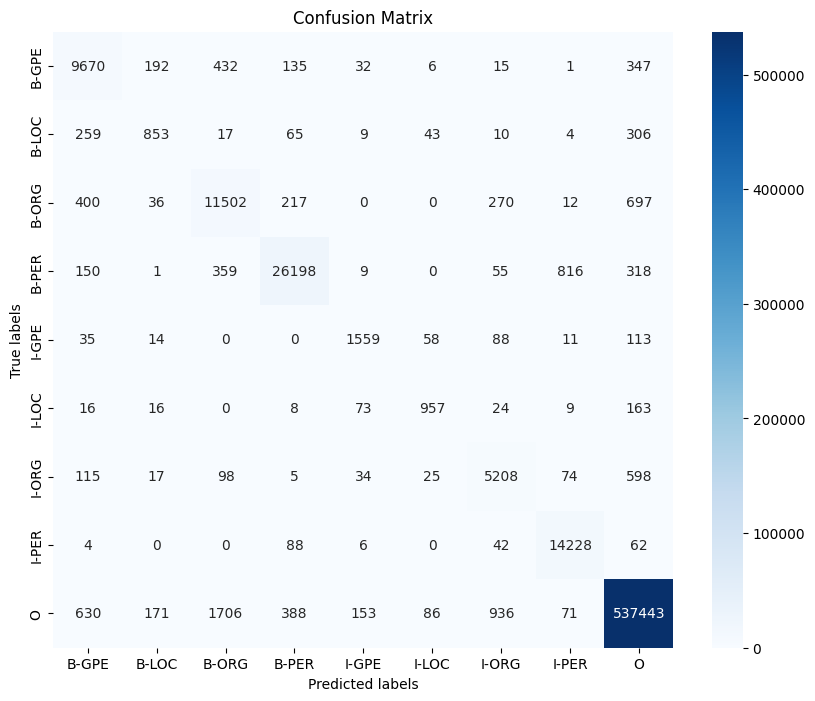

In [31]:
conf_matrix = confusion_matrix(np.concatenate(stored_labels), np.concatenate(stored_predictions))
labels = sorted(list(set(np.concatenate(stored_labels))))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
id2label= {
    str(i):label for i, label in enumerate(label_list)
}

label2id = {
    label:str(i) for i, label in enumerate(label_list)
}

In [33]:
import json

config = json.load(open('ner_model/config.json'))

In [34]:
config['id2label'] = id2label
config['label2id'] = label2id

json.dump(config, open('ner_model/config.json', 'w'))

model_fine_tuned = AutoModelForTokenClassification.from_pretrained("ner_model")

Final test on a randomm input text

In [35]:
from transformers import pipeline

In [36]:
nlp = pipeline("ner", model=model_fine_tuned, tokenizer=tokenizer)

example = "Cristina e Gianluca fanno parte dell'ADMO e vivono in Trentino"

ner_results = nlp(example)

print(ner_results)

[{'entity': 'B-PER', 'score': 0.9986218, 'index': 1, 'word': 'Cristina', 'start': 0, 'end': 8}, {'entity': 'B-PER', 'score': 0.9980684, 'index': 3, 'word': 'Gian', 'start': 11, 'end': 15}, {'entity': 'B-PER', 'score': 0.9972234, 'index': 4, 'word': '##lu', 'start': 15, 'end': 17}, {'entity': 'B-PER', 'score': 0.99745446, 'index': 5, 'word': '##ca', 'start': 17, 'end': 19}, {'entity': 'B-ORG', 'score': 0.9994461, 'index': 10, 'word': 'AD', 'start': 37, 'end': 39}, {'entity': 'B-ORG', 'score': 0.99939394, 'index': 11, 'word': '##MO', 'start': 39, 'end': 41}, {'entity': 'B-GPE', 'score': 0.9978048, 'index': 15, 'word': 'Trentino', 'start': 54, 'end': 62}]
